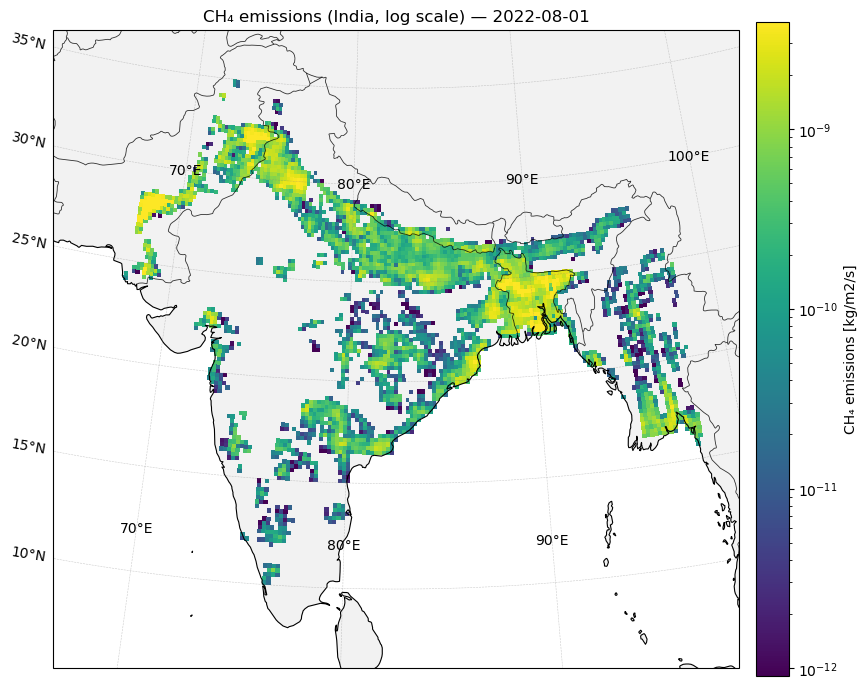

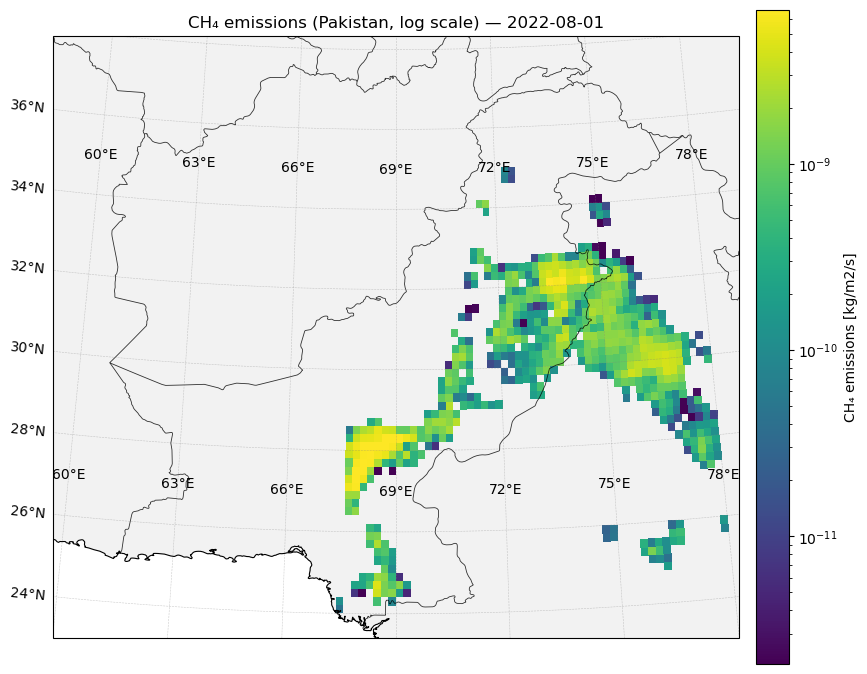

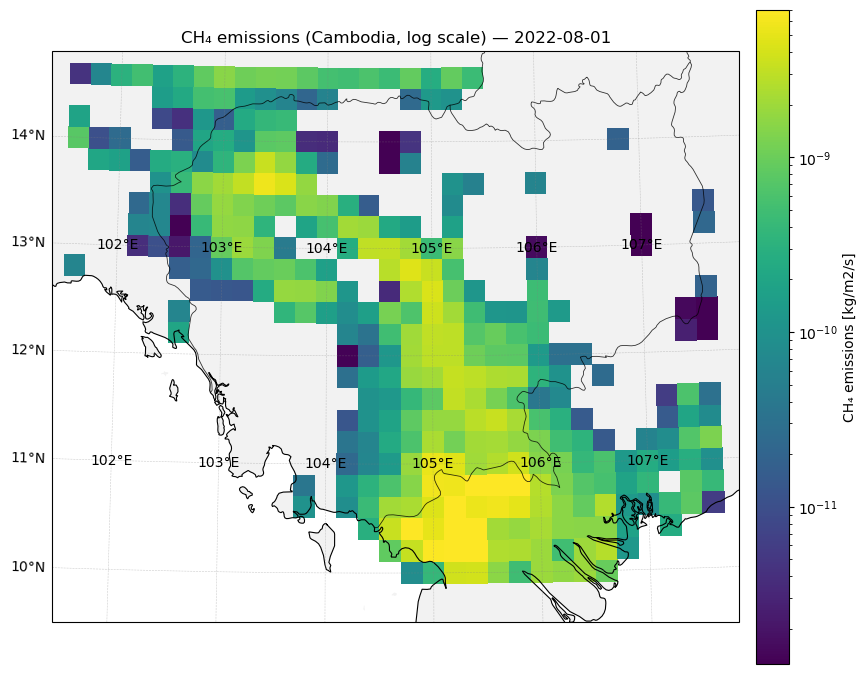

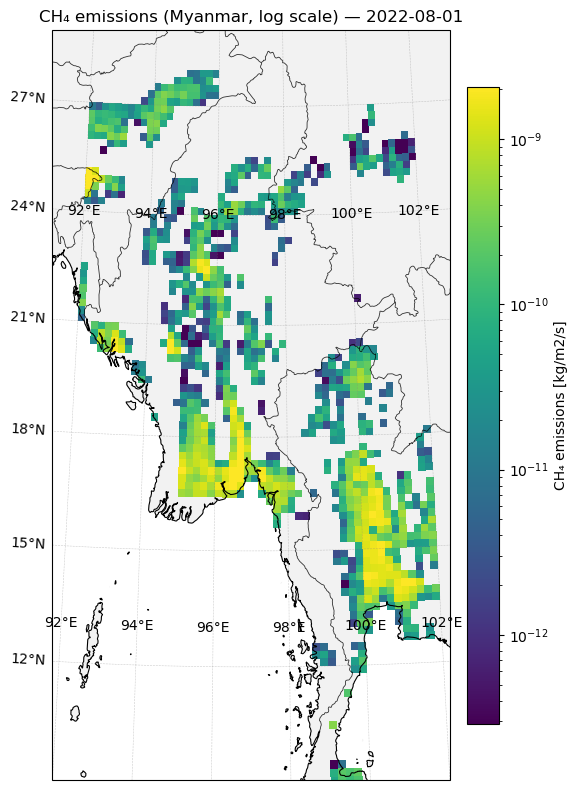

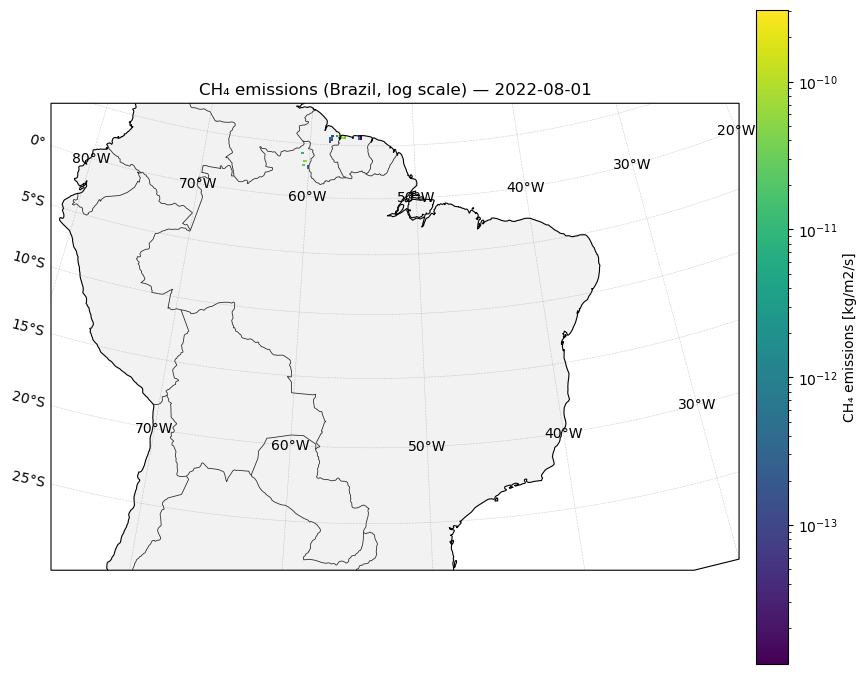

In [20]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LogNorm

# Any month is fine
TIME = "2022-08-01"

# Country bounding boxes (lon/lat in degrees), plus a sensible projection center
REGIONS = {
    "India":    {"lon": (67, 98),     "lat": (6, 37),     "center": (82.5, 22.0)},
    "Pakistan": {"lon": (60, 78),     "lat": (23, 38),    "center": (69.0, 30.0)},
    "Cambodia": {"lon": (101.5, 107.8),"lat": (9.5, 14.8),"center": (104.5, 12.2)},
    "Myanmar":  {"lon": (92, 102),    "lat": (9, 29),     "center": (97.0, 19.0)},
    "Brazil":   {"lon": (-75, -30),   "lat": (-35, 6),    "center": (-54.0, -14.0)},
}

# Load
ds = xr.open_dataset("grpi_hemco.nc")
da_all = ds["emi_ch4"].sel(time=TIME)

# Convert lon 0..360 -> -180..180 so regions with negative longitude (e.g., Brazil) work
lon = da_all["lon"]
if float(lon.max()) > 180:
    da_all = da_all.assign_coords(lon=(((lon + 180) % 360) - 180)).sortby("lon")

for name, cfg in REGIONS.items():
    (LON_MIN, LON_MAX) = cfg["lon"]
    (LAT_MIN, LAT_MAX) = cfg["lat"]
    (CLON, CLAT) = cfg["center"]

    # Subset region
    da_reg = da_all.sel(lon=slice(LON_MIN, LON_MAX), lat=slice(LAT_MIN, LAT_MAX))

    # Optional downsample for plotting speed (visualization only)
    da_plot = da_reg.coarsen(lat=2, lon=2, boundary="trim").mean()

    # Log scale requires positive values
    da_pos = da_plot.where(da_plot > 0)

    # Robust limits (prevents hotspots from flattening the map)
    vmin = float(da_pos.quantile(0.02))
    vmax = float(da_pos.quantile(0.98))

    fig = plt.figure(figsize=(9, 8))
    proj = ccrs.LambertConformal(central_longitude=CLON, central_latitude=CLAT)
    ax = plt.axes(projection=proj)

    ax.set_extent([LON_MIN, LON_MAX, LAT_MIN, LAT_MAX], crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.LAND, facecolor="0.95", zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.6, alpha=0.8)

    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.4,
        color="gray",
        alpha=0.4,
        linestyle="--"
    )
    gl.top_labels = False
    gl.right_labels = False

    mesh = ax.pcolormesh(
        da_plot["lon"], da_plot["lat"], da_plot,
        transform=ccrs.PlateCarree(),
        shading="auto",
        cmap="viridis",
        norm=LogNorm(vmin=vmin, vmax=vmax)
    )

    units = da_all.attrs.get("units", "")
    cbar = plt.colorbar(mesh, ax=ax, shrink=0.85, pad=0.02)
    cbar.set_label("CH₄ emissions" + (f" [{units}]" if units else ""))

    ax.set_title(f"CH₄ emissions ({name}, log scale) — {TIME}")

    plt.tight_layout()

    # Optional: save each map
    # plt.savefig(f"emi_ch4_{name.lower().replace(' ', '_')}_log.png", dpi=300, bbox_inches="tight")

    plt.show()
    plt.close(fig)

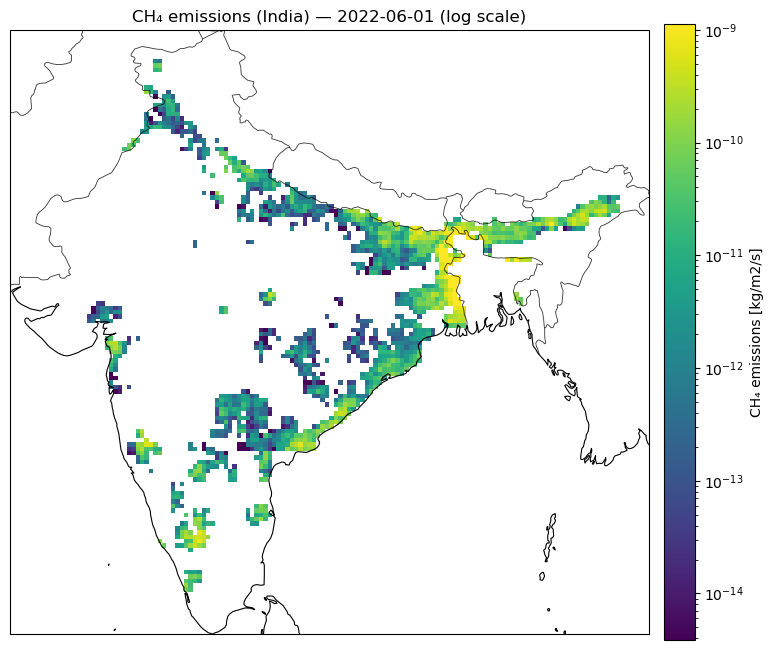

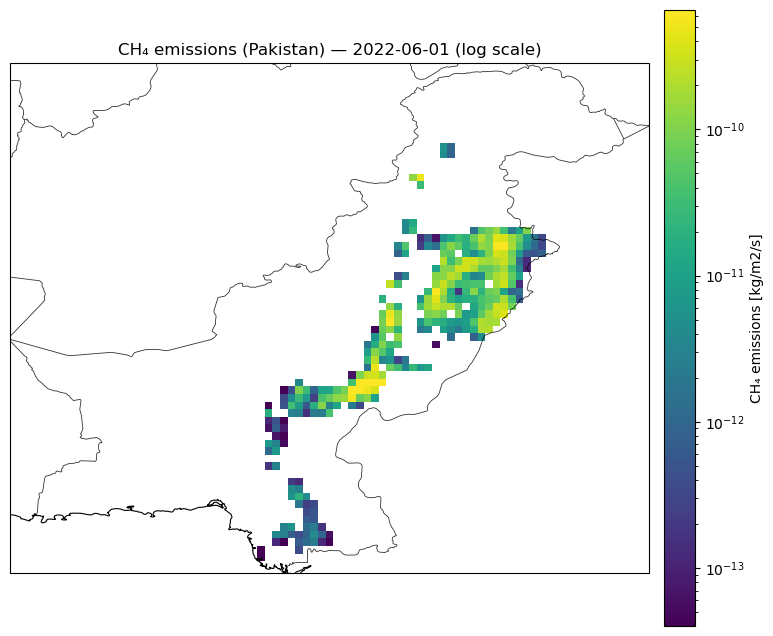

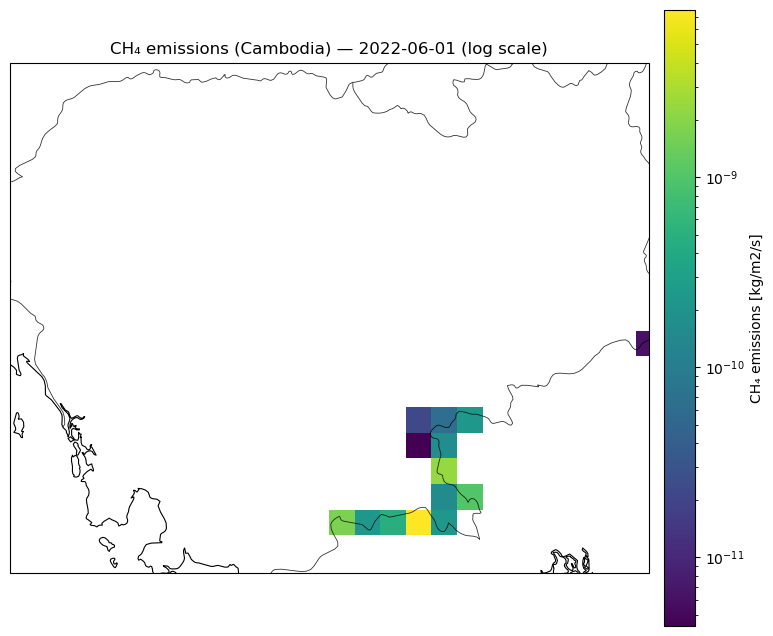

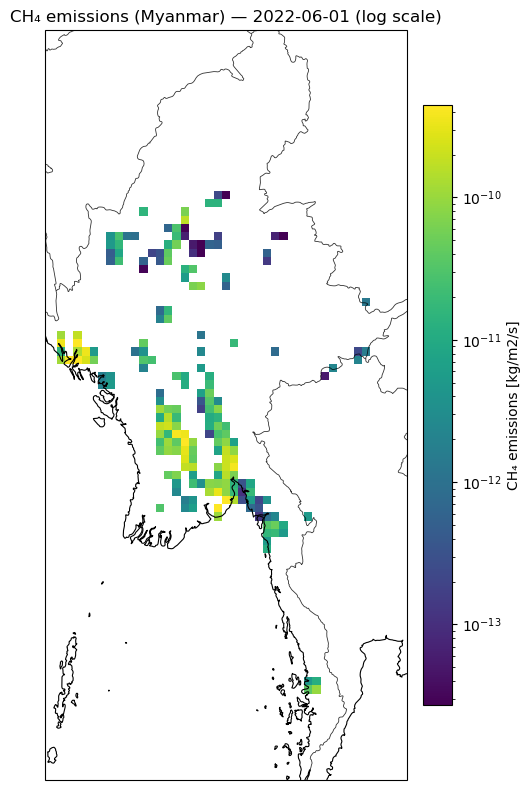

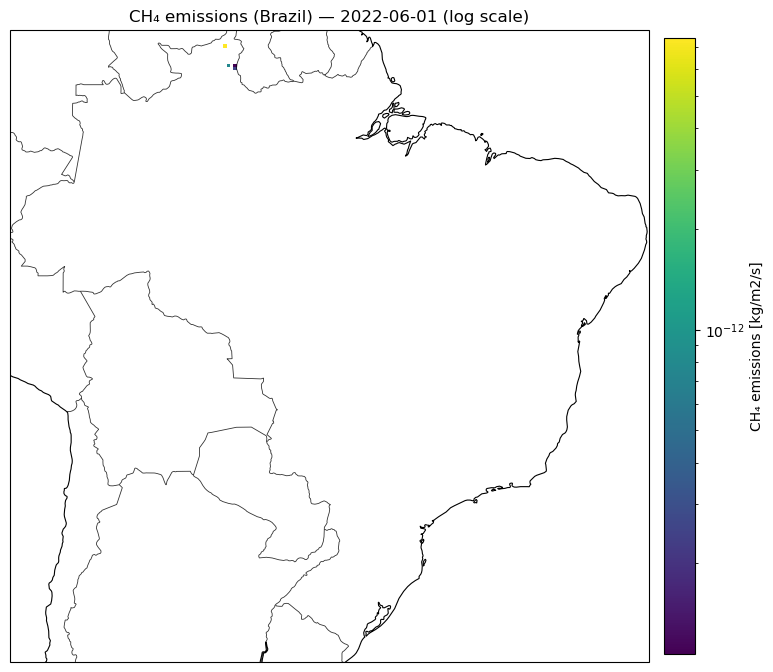

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LogNorm
import regionmask

TIME = "2022-06-01"

COUNTRIES = ["India", "Pakistan", "Cambodia", "Myanmar", "Brazil"]

# --- Load NetCDF ---
ds = xr.open_dataset("grpi_hemco.nc")
da_all = ds["emi_ch4"].sel(time=TIME)

# --- Ensure lon is -180..180 so masking works globally (esp. Brazil) ---
lon = da_all["lon"]
if float(lon.max()) > 180:
    da_all = da_all.assign_coords(lon=(((lon + 180) % 360) - 180)).sortby("lon")

# --- Load Natural Earth country polygons via regionmask ---
# (admin_0 countries; shipped via regionmask datasets)
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

def mask_to_country(da, country_name: str):
    """Return da masked to the given country polygon, outside -> NaN."""
    # Find the country index by name (Natural Earth 'name' attribute)
    # Some names may differ slightly; see notes below if a name doesn't match.
    names = list(countries.names)
    if country_name not in names:
        # Try a simple fallback search
        matches = [n for n in names if n.lower() == country_name.lower()]
        if not matches:
            raise ValueError(f"Country '{country_name}' not found in Natural Earth names.")
        country_name = matches[0]

    country_idx = names.index(country_name)

    # Create a mask array with region numbers on the da grid
    # mask values: region number where inside, NaN outside
    m = countries.mask(da)

    # Keep only cells inside this country
    return da.where(m == country_idx)

for name in COUNTRIES:
    da_country = mask_to_country(da_all, name)

    # Optional: coarsen AFTER masking (faster plotting; keep analysis at full res)
    da_plot = da_country.coarsen(lat=2, lon=2, boundary="trim").mean()

    # LogNorm requires positive values
    da_pos = da_plot.where(da_plot > 0)

    # Robust scaling (per-country). If you want ONE shared scale, see note below.
    vmin = float(da_pos.quantile(0.02))
    vmax = float(da_pos.quantile(0.98))

    # Plot
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_title(f"CH₄ emissions ({name}) — {TIME} (log scale)")

    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.6, alpha=0.8)

    # Set extent to the country’s bounding box from the masked data
    # (drop NaNs to avoid empty slices)
    da_nonan = da_plot.dropna("lat", how="all").dropna("lon", how="all")
    if da_nonan.sizes.get("lat", 0) == 0 or da_nonan.sizes.get("lon", 0) == 0:
        print(f"Skipping {name}: no data after masking (check country name).")
        plt.close(fig)
        continue

    ax.set_extent(
        [float(da_nonan.lon.min()), float(da_nonan.lon.max()),
         float(da_nonan.lat.min()), float(da_nonan.lat.max())],
        crs=ccrs.PlateCarree()
    )

    mesh = ax.pcolormesh(
        da_plot["lon"], da_plot["lat"], da_plot,
        shading="auto",
        cmap="viridis",
        norm=LogNorm(vmin=vmin, vmax=vmax),
        transform=ccrs.PlateCarree(),
    )

    units = da_all.attrs.get("units", "")
    cbar = plt.colorbar(mesh, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label("CH₄ emissions" + (f" [{units}]" if units else ""))

    plt.tight_layout()
    # plt.savefig(f"emi_ch4_{name.lower().replace(' ', '_')}_masked_log.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)


    country        time       total
0     India  2022-08-01  453.463233
1  Pakistan  2022-08-01  247.255519
2  Cambodia  2022-08-01   98.178609
3   Myanmar  2022-08-01   74.547175
4    Brazil  2022-08-01    0.069346


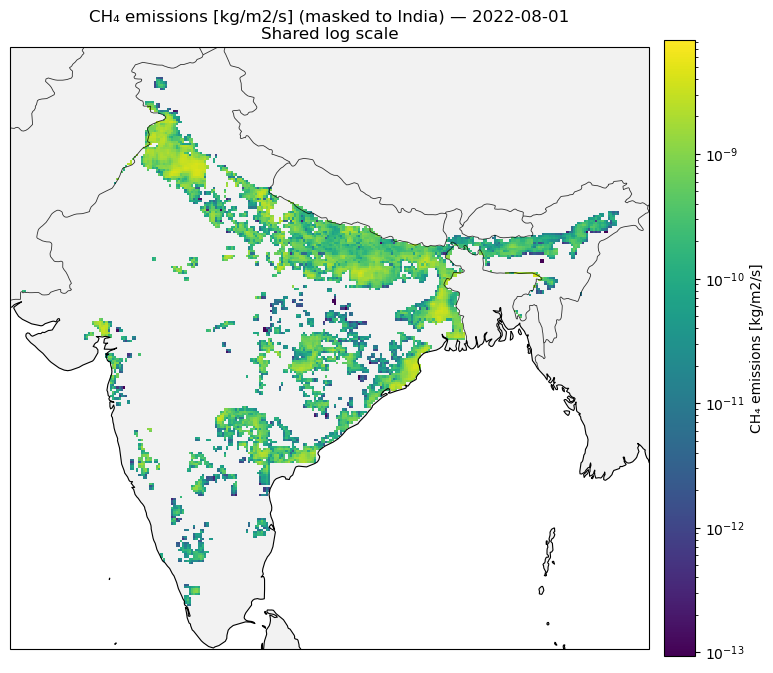

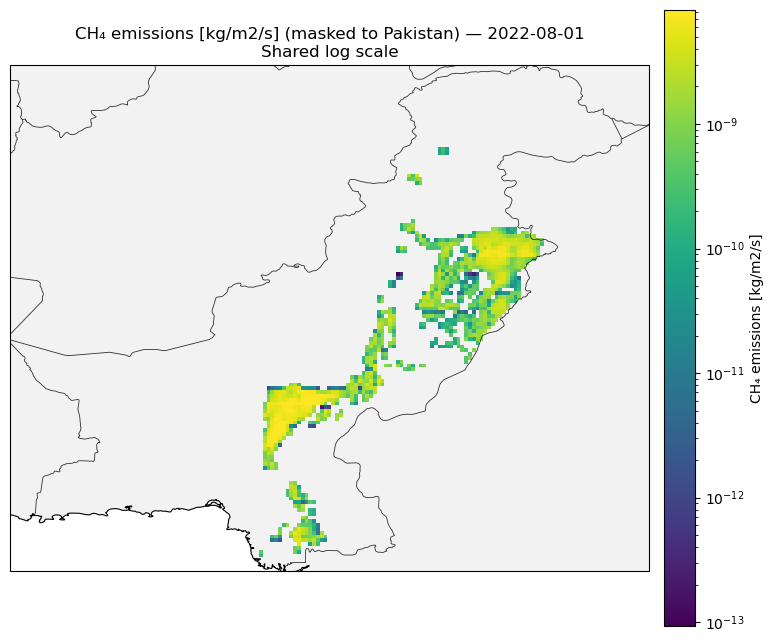

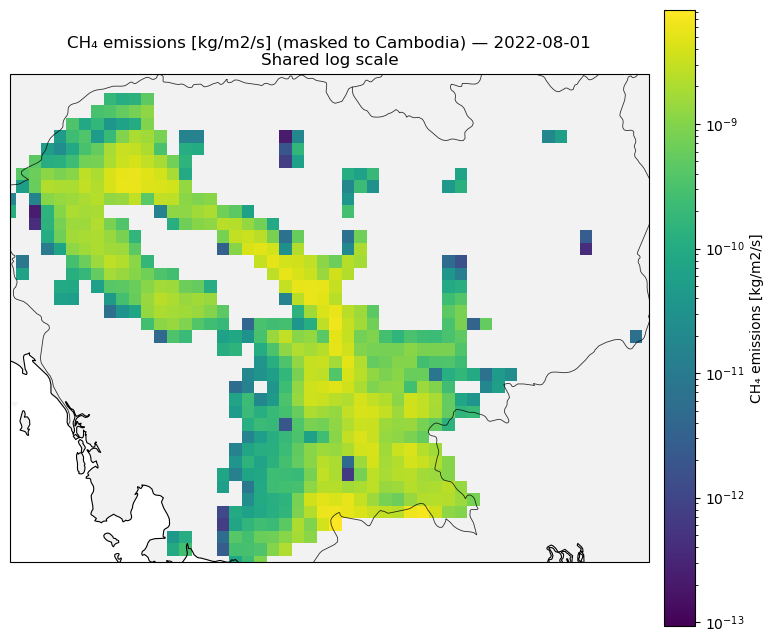

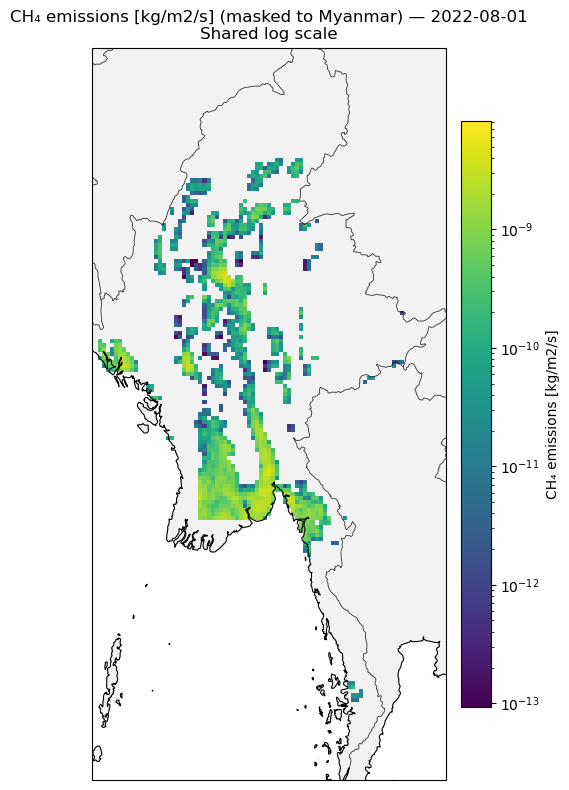

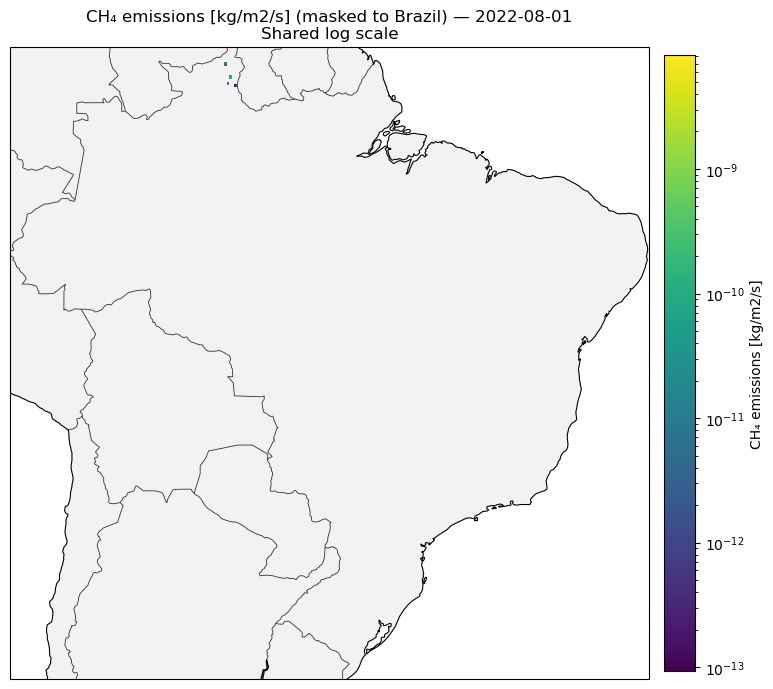


Shared log scale: vmin=9.33e-14, vmax=8.23e-09


In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LogNorm
import regionmask

# ---------------------------
# Settings
# ---------------------------
TIME = "2022-08-01"  # any month
COUNTRIES = ["India", "Pakistan", "Cambodia", "Myanmar", "Brazil"]
COARSEN_FOR_PLOTTING = 1  # set to 1 for full res plotting

# ---------------------------
# Helpers
# ---------------------------
def to_lon180(da):
    """Convert lon from 0..360 to -180..180 if needed."""
    lon = da["lon"]
    if float(lon.max()) > 180:
        da = da.assign_coords(lon=(((lon + 180) % 360) - 180)).sortby("lon")
    return da

import numpy as np
import xarray as xr

def gridcell_area_m2(lat, lon):
    """
    Compute spherical-Earth gridcell areas for 1D lat/lon coordinates.
    Returns DataArray area(lat, lon) in m^2 with shape (nlat, nlon).
    Works for regular grids (and is robust if spacing is nearly-regular).
    """
    R = 6371000.0  # meters

    lat = lat.astype(float).values
    lon = lon.astype(float).values

    # Build "edges" from center coords using gradient spacing
    dlat = np.deg2rad(np.gradient(lat))  # length nlat
    dlon = np.deg2rad(np.gradient(lon))  # length nlon

    lat_rad = np.deg2rad(lat)

    # Latitude edges: phi_s = phi - dphi/2, phi_n = phi + dphi/2
    phi_s = lat_rad - dlat / 2
    phi_n = lat_rad + dlat / 2

    # Area per (lat, lon) cell on a sphere:
    # A = R^2 * dlon * (sin(phi_n) - sin(phi_s))
    band = (np.sin(phi_n) - np.sin(phi_s))  # length nlat

    area_2d = (R**2) * band[:, None] * dlon[None, :]  # (nlat, nlon)

    return xr.DataArray(
        area_2d,
        coords={"lat": lat, "lon": lon},
        dims=("lat", "lon"),
        name="cell_area",
    )


def mask_to_country(da, countries_regions, country_name):
    """Mask da to the given country polygon (outside -> NaN)."""
    names = list(countries_regions.names)
    if country_name not in names:
        # Case-insensitive fallback
        matches = [n for n in names if n.lower() == country_name.lower()]
        if not matches:
            raise ValueError(f"Country '{country_name}' not found in Natural Earth names.")
        country_name = matches[0]

    country_idx = names.index(country_name)
    m = countries_regions.mask(da)  # version-safe (no lat_name/lon_name)
    return da.where(m == country_idx)

def nice_extent_from_masked(da_masked):
    """Get a plotting extent from a masked DataArray."""
    da_nonan = da_masked.dropna("lat", how="all").dropna("lon", how="all")
    return [
        float(da_nonan.lon.min()), float(da_nonan.lon.max()),
        float(da_nonan.lat.min()), float(da_nonan.lat.max())
    ]

# ---------------------------
# Load data
# ---------------------------
ds = xr.open_dataset("grpi_hemco.nc")
da = ds["emi_ch4"].sel(time=TIME)
da = to_lon180(da)

# Countries polygons
countries_regions = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

# Cell areas on the grid
area = gridcell_area_m2(da["lat"], da["lon"])

# ---------------------------
# Build country-masked fields (full-res for totals, optional coarsen for plotting)
# ---------------------------
masked_full = {}
masked_plot = {}

for c in COUNTRIES:
    da_c = mask_to_country(da, countries_regions, c)
    masked_full[c] = da_c

    if COARSEN_FOR_PLOTTING and COARSEN_FOR_PLOTTING > 1:
        masked_plot[c] = da_c.coarsen(
            lat=COARSEN_FOR_PLOTTING, lon=COARSEN_FOR_PLOTTING, boundary="trim"
        ).mean()
    else:
        masked_plot[c] = da_c

# ---------------------------
# 1) Shared log color scale across all countries
#    Practical robust approach: compute each country's robust (2%, 98%) on positives,
#    then take the overall min/max across countries.
# ---------------------------
vmins = []
vmaxs = []
for c in COUNTRIES:
    da_pos = masked_plot[c].where(masked_plot[c] > 0)
    # If a country has no positive data (unlikely), skip safely
    if da_pos.notnull().any():
        vmins.append(float(da_pos.quantile(0.02)))
        vmaxs.append(float(da_pos.quantile(0.98)))

shared_vmin = min(vmins)
shared_vmax = max(vmaxs)

# ---------------------------
# 2) National totals (area-integrated)
#    NOTE: Units depend on emi_ch4 units.
#    If emi_ch4 is a flux (e.g., kg m-2 s-1), totals are kg s-1 after area integration.
#    If emi_ch4 is per-area per-month, totals become "per-month" mass after integration.
# ---------------------------
totals = []
for c in COUNTRIES:
    # Multiply by gridcell area and sum over space
    total = (masked_full[c] * area).sum(dim=["lat", "lon"], skipna=True)
    totals.append({"country": c, "time": str(da["time"].values)[:10], "total": float(total.values)})

totals_df = pd.DataFrame(totals)
print(totals_df)

# ---------------------------
# Plot maps (shared scale)
# ---------------------------
units = da.attrs.get("units", "")
label = "CH₄ emissions" + (f" [{units}]" if units else "")

for c in COUNTRIES:
    da_c = masked_plot[c]

    # Skip empty masks
    if not da_c.notnull().any():
        print(f"Skipping {c}: no data after masking (check country name in Natural Earth).")
        continue

    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.add_feature(cfeature.LAND, facecolor="0.95", zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.6, alpha=0.8)

    ax.set_extent(nice_extent_from_masked(da_c), crs=ccrs.PlateCarree())

    mesh = ax.pcolormesh(
        da_c["lon"], da_c["lat"], da_c,
        transform=ccrs.PlateCarree(),
        shading="auto",
        cmap="viridis",
        norm=LogNorm(vmin=shared_vmin, vmax=shared_vmax)
    )

    cbar = plt.colorbar(mesh, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label(label)

    ax.set_title(f"{label} (masked to {c}) — {TIME}\nShared log scale")
    plt.tight_layout()

    # Optional save:
    # plt.savefig(f"emi_ch4_{c.lower().replace(' ', '_')}_masked_sharedlog.png", dpi=300, bbox_inches="tight")

    plt.show()
    plt.close(fig)

print(f"\nShared log scale: vmin={shared_vmin:.3g}, vmax={shared_vmax:.3g}")